In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

# torch.set_default_dtype(torch.float64)

In [2]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input

class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)

        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )

def local_environment(coords: Tensor) -> Tuple[Tensor, Tensor]:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    dij = torch.norm(rij, dim=3)
    mask = ~torch.eye(num_channels, dtype=torch.bool) # remove self-distance
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    dij = torch.masked_select(dij, mask).view(num_batches, num_channels, num_channels - 1)
    dij_inv = 1 / dij
    dij2_inv = dij_inv * dij_inv

    loc_env_r = dij_inv * 6 - 2
    loc_env_a = rij * dij2_inv.unsqueeze(3)

    return loc_env_r, loc_env_a

def electric_efield(atom_coords: Tensor, charge_coords: Tensor, charges: Tensor) -> Tuple[Tensor, Tensor]:
    rij = atom_coords[:, :, None] - charge_coords[:, None]
    dij = torch.norm(rij, dim=3)
    esp = torch.sum(charges[..., None, :] / dij, dim=-1) * (27.2114 * 0.529177249 / 2) - 3.5
    efield = torch.sum(charges[..., None, :, None] * rij / (dij**3)[..., None], dim=-2) * (27.2114 * 0.529177249)
    return esp, efield

class Feature(nn.Module):
    def __init__(self, n_types: int, neuron: Sequence[int] = [25, 50, 100], axis_neuron: int = 4) -> None:
        super().__init__()
        self.n_types = n_types
        self.neuron = neuron
        self.axis_neuron = axis_neuron

        layers = [Dense(n_types * n_types, 1, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types * n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        self.local_embedding = Sequential(*layers)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        loc_env_r, loc_env_a = local_environment(coords)

        neighbor_types = atom_types.repeat(num_channels, 1)
        mask = ~torch.eye(num_channels, dtype=torch.bool)
        neighbor_types = torch.masked_select(neighbor_types, mask).view(num_channels, -1)
        indices = ((atom_types * self.n_types).unsqueeze(-1) + neighbor_types).view(-1)

        output, _ = self.local_embedding((loc_env_r.view(num_batches, -1, 1), indices))
        output = output.view(num_batches, num_channels, num_channels - 1, -1)

        output = torch.transpose(output, 2, 3) @ (loc_env_a @ (torch.transpose(loc_env_a, 2, 3) @ output[..., :self.axis_neuron]))
        output = output.view(num_batches, num_channels, -1) / 4

        return output

    @property
    def output_length(self) -> int:
        return self.neuron[-1] * self.axis_neuron

class ElectrostaticPotential(nn.Module):
    def __init__(self, n_types: int, neuron: Sequence[int] = [5, 10, 20], axis_neuron: int = 4) -> None:
        super().__init__()
        self.n_types = n_types
        self.neuron = neuron
        self.axis_neuron = axis_neuron

        layers = [Dense(n_types, 1, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        self.esp_embedding = Sequential(*layers)

        layers = [Dense(n_types * n_types, 1, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types * n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        self.efield_embedding = Sequential(*layers)

    def forward(self, atom_coords: Tensor, atom_types: Tensor, charge_coords: Tensor, charges: Tensor) -> Tensor:
        num_batches, num_channels, _ = atom_coords.size()
        _, loc_env_a = local_environment(atom_coords)
        esp, efield = electric_efield(atom_coords, charge_coords, charges)
        esp_output, _ = self.esp_embedding((esp.unsqueeze(-1), atom_types))

        output = torch.bmm(loc_env_a.view(-1, num_channels - 1, 3), efield.view(-1, 3, 1)).view(num_batches, num_channels, num_channels - 1)

        neighbor_types = atom_types.repeat(num_channels, 1)
        mask = ~torch.eye(num_channels, dtype=torch.bool)
        neighbor_types = torch.masked_select(neighbor_types, mask).view(num_channels, -1)
        indices = ((atom_types * self.n_types).unsqueeze(-1) + neighbor_types).view(-1)

        output, _ = self.efield_embedding((output.view(num_batches, -1, 1), indices))
        output = output.view(num_batches, num_channels, num_channels - 1, -1)

        output = torch.transpose(output, 2, 3) @ output[..., :self.axis_neuron]
        output = output.view(num_batches, num_channels, -1) / 8

        output = torch.cat((esp_output, output), dim=2)

        return output

    @property
    def output_length(self) -> int:
        return self.neuron[-1] * (self.axis_neuron + 1)

In [4]:
class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

class DeepPotMM(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, esp: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.esp = esp
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor, charge_coords: torch.Tensor, charges: torch.Tensor):
        coords.requires_grad_()
        charge_coords.requires_grad_()
        charges.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        esp = self.esp(coords, atom_types, charge_coords, charges)
        descriptors = torch.cat((descriptors, esp), dim=-1)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, mm_esp, charge_gradient = torch.autograd.grad(energy, [coords, charges, charge_coords], create_graph=True)
        if charge_gradient is not None:
            mm_esp_grad = torch.div(charge_gradient, charges.unsqueeze(-1))
        else:
            mm_esp_grad = None
        return torch.hstack(energy), gradient, mm_esp, mm_esp_grad

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, charge_coords, charges, energy, gradient, mm_esp, mm_esp_grad = batch
        ene_pred, grad_pred, mm_esp_pred, mm_esp_grad_pred = self(qm_coord, atom_types[0], charge_coords, charges)
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)
        mm_esp_loss = F.mse_loss(mm_esp_pred, mm_esp)
        mm_esp_grad_loss = F.mse_loss(mm_esp_grad_pred, mm_esp_grad)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * (grad_loss + mm_esp_grad_loss * 10 + mm_esp_loss)
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        self.log('l2_esp_trn', torch.sqrt(mm_esp_loss))
        self.log('l2_espg_trn', torch.sqrt(mm_esp_grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, charge_coords, charges, energy, gradient, mm_esp, mm_esp_grad = batch
        ene_pred, grad_pred, mm_esp_pred, mm_esp_grad_pred = self(qm_coord, atom_types[0], charge_coords, charges)
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)
        mm_esp_loss = F.mse_loss(mm_esp_pred, mm_esp)
        mm_esp_grad_loss = F.mse_loss(mm_esp_grad_pred, mm_esp_grad)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * (grad_loss + mm_esp_grad_loss * 10 + mm_esp_loss)
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('l2_esp_tst', torch.sqrt(mm_esp_loss))
        self.log('l2_espg_tst', torch.sqrt(mm_esp_grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 5,
                    }
        return [optimizer], [scheduler]

In [5]:
qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float32"))
atom_types = torch.from_numpy(np.array(np.loadtxt("type.raw"), dtype="int64"))
atom_types = atom_types.repeat(len(qm_coord), 1)

mm_coord = torch.from_numpy(np.array(np.load("mm_coord.npy"), dtype="float32"))
mm_charge = torch.from_numpy(np.array(np.load("mm_charge.npy"), dtype="float32"))

energy = torch.from_numpy(np.array(np.load("energy1.npy") - np.load("energy_sqm.npy"), dtype="float32")) * 27.2114
energy = energy - energy.mean()
qm_gradient = torch.from_numpy(np.array(np.load("qm_grad1.npy") - np.load("qm_grad_sqm.npy"), dtype="float32")) * 27.2114 / 0.529177249
mm_esp = torch.from_numpy(np.array(np.load("mm_esp1.npy") - np.load("mm_esp_sqm.npy"), dtype="float32")) * 27.2114
mm_esp_grad = -torch.from_numpy(np.array(np.load("mm_efield1.npy") - np.load("mm_efield_sqm.npy"), dtype="float32")) * 27.2114 / 0.529177249

In [7]:
# checking inputs
print("QM Coord: ", qm_coord.shape)
print("Atom Type: ", atom_types.shape)
print("MM Coord: ", mm_coord.shape)
print("MM Charge: ", mm_charge.shape)
print("Energy: ", energy.shape)
print("QM Grad: ", qm_gradient.shape)
print("MM ESP: ", mm_esp.shape)
print("MM ESP Grad: ", mm_esp_grad.shape)

QM Coord:  torch.Size([36288, 68, 3])
Atom Type:  torch.Size([36288, 68])
MM Coord:  torch.Size([36288, 773, 3])
MM Charge:  torch.Size([36288, 773])
Energy:  torch.Size([36288])
QM Grad:  torch.Size([36288, 68, 3])
MM ESP:  torch.Size([36288, 773])
MM ESP Grad:  torch.Size([36288, 773, 3])


In [14]:
pl.seed_everything(0)
dataset = TensorDataset(qm_coord, atom_types, mm_coord, mm_charge, energy, qm_gradient, mm_esp, mm_esp_grad)
train, val = random_split(dataset, [32000, 4288])
train_loader = DataLoader(train, batch_size=32, num_workers=16)
val_loader = DataLoader(val, batch_size=32, num_workers=16)

Global seed set to 0


In [15]:
pl.seed_everything(0)
descriptor = Feature(6, neuron=[25, 50, 100], axis_neuron=4)
esp = ElectrostaticPotential(6, neuron=[5, 10, 20], axis_neuron=4)
fitting_net = Fitting(6, descriptor.output_length + esp.output_length)
model = DeepPotMM(descriptor, esp, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=100, logger=csv_logger, progress_bar_refresh_rate=100, log_every_n_steps=12)
trainer.fit(model, train_loader, val_loader)

Global seed set to 0
/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Set SLURM handle signals.

  | Name        | Type                   | Params
-------------------------------------------------------
0 | descriptor  | Feature                | 232 K 
1 | esp         | ElectrostaticPotential | 12.2 K
2 | fitting_net | Fitting                | 1.4 M 
-------------------------------------------------------
1.7 M     Trainable para

Validation sanity check: 0it [00:00, ?it/s]

/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
torch.save(model.state_dict(), 'model_qmmm_diff.pt')
# model.load_state_dict(torch.load('model_qmmm_diff.pt'))
torch.jit.save(model.to_torchscript(), "model_qmmm_diff_script.pt")
# model = torch.jit.load('model_qmmm_diff_script.pt')

/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/torch/jit/_recursive.py:614: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  item = getattr(mod, name, None)
/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/torch/jit/_recursive.py:614: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name, None)
/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/torch/jit/_recursive.py:701: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(nn_module, name, None)
/home/panxl/.local/opt/miniforge3/lib/python3.8/site-packages/torch/jit/_recursive.py:501: 

In [20]:
qm_coord, atom_types, charge_coord, charges, energy, gradient, mm_esp, mm_esp_grad = val[::]
ene_pred, grad_pred, mm_esp_pred, mm_esp_grad_pred = model(qm_coord, atom_types[0], charge_coord, charges)

Text(0, 0.5, 'Predicted MM ESP (eV/e)')

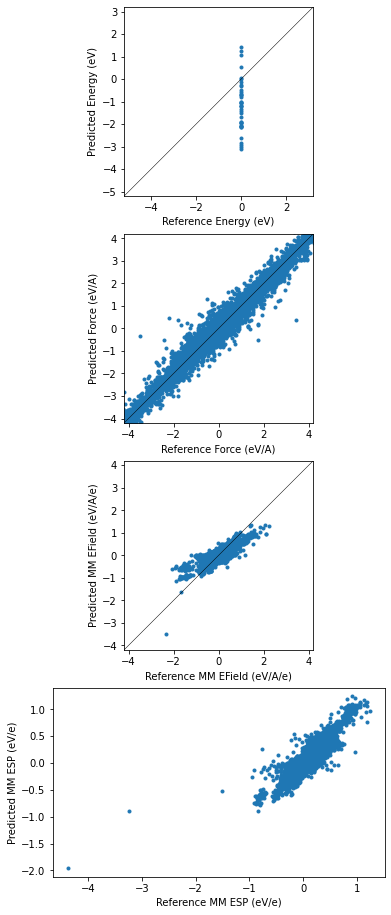

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(24,16))

e1 = energy.detach().numpy()
e2 = ene_pred.detach().numpy()
ax[0].plot(e1, e2, linestyle='none', marker='.', )
ax[0].set_aspect('equal', adjustable='box')
ax[0].plot([-5.2, 3.2], [-5.2, 3.2], color="k", linewidth=0.5)
ax[0].set_xlim(-5.2, 3.2)
ax[0].set_ylim(-5.2, 3.2)
ax[0].set_xlabel("Reference Energy (eV)")
ax[0].set_ylabel("Predicted Energy (eV)")

f1 = -gradient.detach().numpy().reshape(-1)
f2 = -grad_pred.detach().numpy().reshape(-1)
ax[1].plot(f1, f2, linestyle='none', marker='.', )
ax[1].set_aspect('equal', adjustable='box')
ax[1].plot([-4.2, 4.2], [-4.2, 4.2], color="k", linewidth=0.5)
ax[1].set_xlim(-4.2, 4.2)
ax[1].set_ylim(-4.2, 4.2)
ax[1].set_xlabel("Reference Force (eV/A)")
ax[1].set_ylabel("Predicted Force (eV/A)")

fmm1 = mm_esp_grad.detach().numpy().reshape(-1)
fmm2 = mm_esp_grad_pred.detach().numpy().reshape(-1)
ax[2].plot(fmm1, fmm2, linestyle='none', marker='.', )
ax[2].set_aspect('equal', adjustable='box')
ax[2].plot([-4.2, 4.2], [-4.2, 4.2], color="k", linewidth=0.5)
ax[2].set_xlim(-4.2, 4.2)
ax[2].set_ylim(-4.2, 4.2)
ax[2].set_xlabel("Reference MM EField (eV/A/e)")
ax[2].set_ylabel("Predicted MM EField (eV/A/e)")

esp1 = mm_esp.detach().numpy().reshape(-1)
esp2 = mm_esp_pred.detach().numpy().reshape(-1)
ax[3].plot(esp1, esp2, linestyle='none', marker='.', )
ax[3].set_aspect('equal', adjustable='box')
# ax[3].plot([-4.2, 4.2], [-4.2, 4.2], color="k", linewidth=0.5)
# ax[3].set_xlim(-4.2, 4.2)
# ax[3].set_ylim(-4.2, 4.2)
ax[3].set_xlabel("Reference MM ESP (eV/e)")
ax[3].set_ylabel("Predicted MM ESP (eV/e)")

In [18]:
torch.sqrt(F.mse_loss(ene_pred, energy)), torch.sqrt(F.mse_loss(grad_pred, gradient)), torch.sqrt(F.mse_loss(mm_esp_grad_pred, mm_esp_grad)), torch.sqrt(F.mse_loss(mm_esp_pred, mm_esp)),

(tensor(1.6196, grad_fn=<SqrtBackward0>),
 tensor(0.2727, grad_fn=<SqrtBackward0>),
 tensor(0.0446, grad_fn=<SqrtBackward0>),
 tensor(0.0492, grad_fn=<SqrtBackward0>))

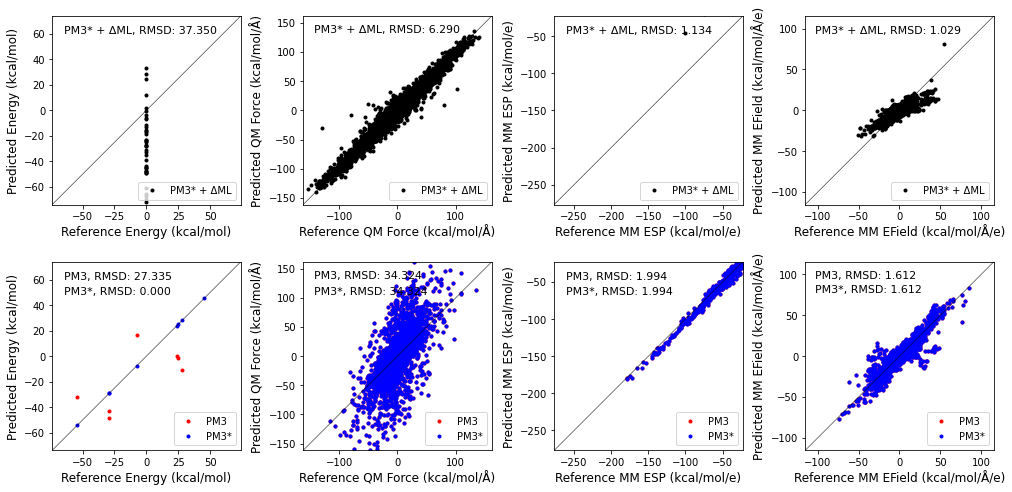

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7))

e1 = energy.detach().numpy() * 23.061
e2 = ene_pred.detach().numpy() * 23.061
ax[0, 0].plot(e1, e2, linestyle='none', marker='.', color="k", label="PM3* + ΔML")
ax[0, 0].set_aspect('equal', adjustable='box')
ax[0, 0].plot([-3.2*23.061, 3.2*23.061], [-3.2*23.061, 3.2*23.061], color="k", linewidth=0.5)
ax[0, 0].set_xlim(-3.2*23.061, 3.2*23.061)
ax[0, 0].set_ylim(-3.2*23.061, 3.2*23.061)
ax[0, 0].set_xlabel("Reference Energy (kcal/mol)", size=12)
ax[0, 0].set_ylabel("Predicted Energy (kcal/mol)", size=12)
ax[0, 0].text(-2.8*23.061, 2.6*23.061, 'PM3* + ΔML, RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), size=11)

f1 = -gradient.detach().numpy().reshape(-1) * 23.061
f2 = -grad_pred.detach().numpy().reshape(-1) * 23.061
ax[0, 1].plot(f1, f2, linestyle='none', marker='.', color="k", label="PM3* + ΔML")
ax[0, 1].set_aspect('equal', adjustable='box')
ax[0, 1].plot([-7*23.061, 7*23.061], [-7*23.061, 7*23.061], color="k", linewidth=0.5)
ax[0, 1].set_xlim(-7*23.061, 7*23.061)
ax[0, 1].set_ylim(-7*23.061, 7*23.061)
ax[0, 1].set_xlabel("Reference QM Force (kcal/mol/Å)", size=12)
ax[0, 1].set_ylabel("Predicted QM Force (kcal/mol/Å)", size=12)
ax[0, 1].text(-6.2*23.061, 5.8*23.061, 'PM3* + ΔML, RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), size=11)

esp1 = mm_esp.detach().numpy().reshape(-1) * 23.061
esp2 = mm_esp_pred.detach().numpy().reshape(-1) * 23.061
ax[0, 2].plot(esp1, esp2, linestyle='none', marker='.', color="k", label="PM3* + ΔML")
ax[0, 2].set_aspect('equal', adjustable='box')
ax[0, 2].plot([-12*23.061, -1*23.061], [-12*23.061, -1*23.061], color="k", linewidth=0.5)
ax[0, 2].set_xlim(-12*23.061, -1*23.061)
ax[0, 2].set_ylim(-12*23.061, -1*23.061)
ax[0, 2].set_xlabel("Reference MM ESP (kcal/mol/e)", size=12)
ax[0, 2].set_ylabel("Predicted MM ESP (kcal/mol/e)", size=12)
ax[0, 2].text(-11.3*23.061, -2*23.061, 'PM3* + ΔML, RMSD: %.3f' % np.sqrt(np.mean((esp1 - esp2)**2)), size=11)

fmm1 = -mm_esp_grad.detach().numpy().reshape(-1) * 23.061
fmm2 = -mm_esp_grad_pred.detach().numpy().reshape(-1) * 23.061
ax[0, 3].plot(fmm1, fmm2, linestyle='none', marker='.', color="k", label="PM3* + ΔML")
ax[0, 3].set_aspect('equal', adjustable='box')
ax[0, 3].plot([-5*23.061, 5*23.061], [-5*23.061, 5*23.061], color="k", linewidth=0.5)
ax[0, 3].set_xlim(-5*23.061, 5*23.061)
ax[0, 3].set_ylim(-5*23.061, 5*23.061)
ax[0, 3].set_xlabel("Reference MM EField (kcal/mol/Å/e)", size=12)
ax[0, 3].set_ylabel("Predicted MM EField (kcal/mol/Å/e)", size=12)
ax[0, 3].text(-4.5*23.061, 4.1*23.061, 'PM3* + ΔML, RMSD: %.3f' % np.sqrt(np.mean((fmm1 - fmm2)**2)), size=11)

e1 = np.array(np.load("energy1.npy"), dtype="float32")[::40] * 27.2114 * 23.061
e1 = e1 - e1.mean()
f1 = np.load("qm_grad1.npy")[::40] * 27.2114 / 0.529177249 * 23.061
esp1 = np.load("mm_esp1.npy")[::40] * 27.2114 * 23.061
fm1 = np.load("mm_efield1.npy")[::40] * 27.2114 / 0.529177249 * 23.061
e2 = np.array(np.load("energy_sqm.npy"), dtype="float32")[::40] * 27.2114 * 23.061
e2 = e2 - e2.mean()
f2 = np.load("qm_grad_sqm.npy")[::40] * 27.2114 / 0.529177249 * 23.061
esp2 = np.load("mm_esp_sqm.npy")[::40] * 27.2114 * 23.061
fm2 = np.load("mm_efield_sqm.npy")[::40] * 27.2114 / 0.529177249 * 23.061
e3 = np.array(np.load("energy1_sqm.npy"), dtype="float32")[::40] * 27.2114 * 23.061
e3 = e3 - e3.mean()
f3 = np.load("qm_grad_sqm.npy")[::40] * 27.2114 / 0.529177249 * 23.061
esp3 = np.load("mm_esp_sqm.npy")[::40] * 27.2114 * 23.061
fm3 = np.load("mm_efield_sqm.npy")[::40] * 27.2114 / 0.529177249 * 23.061

ax[1, 0].plot(e1, e2, linestyle='none', marker='.', color="r", label="PM3")
ax[1, 0].plot(e1, e3, linestyle='none', marker='.', color="b", label="PM3*")
ax[1, 0].set_aspect('equal', adjustable='box')
ax[1, 0].plot([-3.2*23.061, 3.2*23.061], [-3.2*23.061, 3.2*23.061], color="k", linewidth=0.5)
ax[1, 0].set_xlim(-3.2*23.061, 3.2*23.061)
ax[1, 0].set_ylim(-3.2*23.061, 3.2*23.061)
ax[1, 0].set_xlabel("Reference Energy (kcal/mol)", size=12)
ax[1, 0].set_ylabel("Predicted Energy (kcal/mol)", size=12)
ax[1, 0].text(-2.8*23.061, 2.6*23.061, 'PM3, RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), size=11)
ax[1, 0].text(-2.8*23.061, 2.1*23.061, 'PM3*, RMSD: %.3f' % np.sqrt(np.mean((e1 - e3)**2)), size=11)

ax[1, 1].plot(f1.flatten(), f2.flatten(), linestyle='none', marker='.', color="r", label="PM3")
ax[1, 1].plot(f1.flatten(), f3.flatten(), linestyle='none', marker='.', color="b", label="PM3*")
ax[1, 1].set_aspect('equal', adjustable='box')
ax[1, 1].plot([-7*23.061, 7*23.061], [-7*23.061, 7*23.061], color="k", linewidth=0.5)
ax[1, 1].set_xlim(-7*23.061, 7*23.061)
ax[1, 1].set_ylim(-7*23.061, 7*23.061)
ax[1, 1].set_xlabel("Reference QM Force (kcal/mol/Å)", size=12)
ax[1, 1].set_ylabel("Predicted QM Force (kcal/mol/Å)", size=12)
ax[1, 1].text(-6.2*23.061, 5.8*23.061, 'PM3, RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), size=11)
ax[1, 1].text(-6.2*23.061, 4.6*23.061, 'PM3*, RMSD: %.3f' % np.sqrt(np.mean((f1 - f3)**2)), size=11)

ax[1, 2].plot(esp1.flatten(), esp2.flatten(), linestyle='none', marker='.', color="r", label="PM3")
ax[1, 2].plot(esp1.flatten(), esp3.flatten(), linestyle='none', marker='.', color="b", label="PM3*")
ax[1, 2].set_aspect('equal', adjustable='box')
ax[1, 2].plot([-12*23.061, -1*23.061], [-12*23.061, -1*23.061], color="k", linewidth=0.5)
ax[1, 2].set_xlim(-12*23.061, -1*23.061)
ax[1, 2].set_ylim(-12*23.061, -1*23.061)
ax[1, 2].set_xlabel("Reference MM ESP (kcal/mol/e)", size=12)
ax[1, 2].set_ylabel("Predicted MM ESP (kcal/mol/e)", size=12)
ax[1, 2].text(-11.3*23.061, -2*23.061, 'PM3, RMSD: %.3f' % np.sqrt(np.mean((esp1 - esp2)**2)), size=11)
ax[1, 2].text(-11.3*23.061, -2.9*23.061, 'PM3*, RMSD: %.3f' % np.sqrt(np.mean((esp1 - esp3)**2)), size=11)

ax[1, 3].plot(fm1.flatten(), fm2.flatten(), linestyle='none', marker='.', color="r", label="PM3")
ax[1, 3].plot(fm1.flatten(), fm3.flatten(), linestyle='none', marker='.', color="b", label="PM3*")
ax[1, 3].set_aspect('equal', adjustable='box')
ax[1, 3].plot([-5*23.061, 5*23.061], [-5*23.061, 5*23.061], color="k", linewidth=0.5)
ax[1, 3].set_xlim(-5*23.061, 5*23.061)
ax[1, 3].set_ylim(-5*23.061, 5*23.061)
ax[1, 3].set_xlabel("Reference MM EField (kcal/mol/Å/e)", size=12)
ax[1, 3].set_ylabel("Predicted MM EField (kcal/mol/Å/e)", size=12)
ax[1, 3].text(-4.5*23.061, 4.1*23.061, 'PM3, RMSD: %.3f' % np.sqrt(np.mean((fm1 - fm2)**2)), size=11)
ax[1, 3].text(-4.5*23.061, 3.4*23.061, 'PM3*, RMSD: %.3f' % np.sqrt(np.mean((fm1 - fm3)**2)), size=11)

for a in ax.ravel():
    a.legend(loc=4)

fig.tight_layout()
fig.savefig("ml_qmmm_diff.png", dpi=300)

In [2]:
!jupyter nbconvert --to script *.ipynb

[NbConvertApp] Converting notebook ml_qmmm_diff.ipynb to script
[NbConvertApp] Writing 22809 bytes to ml_qmmm_diff.py
